In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
# import tensorflow as tf
# import tensorflow_datasets as tfds
jax.config.update('jax_platform_name', 'gpu')

In [3]:
jax.__version__

'0.4.12'

In [4]:
import jax
import jax.numpy as jnp


## Jax test
jax.config.update('jax_platform_name', 'gpu')


def test_vmap(m):
    return jnp.sin(m)


jax.vmap(test_vmap)(jnp.ones(4))


## Numba test
from numba import jit, cuda
import numpy as np
# to measure exec time
from timeit import default_timer as timer   
  
# normal function to run on cpu
def func(a):                                
    for i in range(10000000):
        a[i]+= 1      
  
# function optimized to run on gpu 
@jit(target_backend='cuda')                         
def func2(a):
    for i in range(10000000):
        a[i]+= 1
if __name__=="__main__":
    n = 10000000                            
    a = np.ones(n, dtype = np.float64)
      
    start = timer()
    func(a)
    print("without GPU:", timer()-start)    
      
    start = timer()
    func2(a)
    print("with GPU:", timer()-start)


2023-06-13 17:35:42.322070: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:427] Loaded runtime CuDNN library: 8.5.0 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

In [ ]:
class MyLinear1(hk.Module):

  def __init__(self, output_size, name=None):
    super().__init__(name=name)
    self.output_size = output_size

  def __call__(self, x):
    j, k = x.shape[-1], self.output_size
    w_init = hk.initializers.TruncatedNormal(1. / np.sqrt(j))
    w = hk.get_parameter("w", shape=[j, k], dtype=x.dtype, init=w_init)
    b = hk.get_parameter("b", shape=[k], dtype=x.dtype, init=jnp.ones)
    return jnp.dot(x, w) + b

In [ ]:
def _forward_fn_linear1(x):
  module = MyLinear1(output_size=2)
  return module(x)

forward_linear1 = hk.transform(_forward_fn_linear1)

In [ ]:
dummy_x = jnp.array([[1., 2., 3.]])
rng_key = jax.random.PRNGKey(42)

params = forward_linear1.init(rng=rng_key, x=dummy_x)
params

{'my_linear1': {'w': Array([[-0.30350366,  0.5123803 ],
         [ 0.08009139, -0.3163005 ],
         [ 0.60566676,  0.5820702 ]], dtype=float32),
  'b': Array([1., 1.], dtype=float32)}}

In [ ]:
sample_x = jnp.array([[1., 2., 3.]])
sample_x_2 = jnp.array([[4., 5., 6.], [7., 8., 9.]])

output_1 = forward_linear1.apply(params=params, x=sample_x, rng=rng_key)
# Outputs are identical for given inputs since the forward inference is non-stochastic.
output_2 = forward_linear1.apply(params=params, x=sample_x, rng=rng_key)

output_3 = forward_linear1.apply(params=params, x=sample_x_2, rng=rng_key)

print(f'Output 1 : {output_1}')
print(f'Output 2 (same as output 1): {output_2}')
print(f'Output 3 : {output_3}')

Output 1 : [[2.6736794 2.62599  ]]
Output 2 (same as output 1): [[2.6736794 2.62599  ]]
Output 3 : [[3.819336  4.9589844]
 [4.965576  7.2924805]]


In [ ]:
forward_without_rng = hk.without_apply_rng(hk.transform(_forward_fn_linear1))
params = forward_without_rng.init(rng=rng_key, x=sample_x)
output = forward_without_rng.apply(x=sample_x, params=params)
print(f'Output without random key in forward pass \n {output}')
print(f'Output w random key in forward pass \n {output_1}')

Output without random key in forward pass 
 [[2.6736794 2.62599  ]]
Output w random key in forward pass 
 [[2.6736794 2.62599  ]]


In [ ]:
params

{'my_linear1': {'w': Array([[-0.30350366,  0.5123803 ],
         [ 0.08009139, -0.3163005 ],
         [ 0.60566676,  0.5820702 ]], dtype=float32),
  'b': Array([1., 1.], dtype=float32)}}

In [ ]:
mutated_params = jax.tree_util.tree_map(lambda x: x+1., params)
print(f'Mutated params \n : {mutated_params}')
mutated_output = forward_without_rng.apply(x=sample_x, params=mutated_params)
print(f'Output with mutated params \n {mutated_output}')

Mutated params 
 : {'my_linear1': {'b': Array([2., 2.], dtype=float32), 'w': Array([[0.69649637, 1.5123804 ],
       [1.0800914 , 0.6836995 ],
       [1.6056668 , 1.5820701 ]], dtype=float32)}}
Output with mutated params 
 [[9.673679 9.62599 ]]


In [ ]:
def stateful_f(x):
  counter = hk.get_state("counter", shape=[], dtype=jnp.int32, init=jnp.ones)
  multiplier = hk.get_parameter('multiplier', shape=[1,], dtype=x.dtype, init=jnp.ones)
  hk.set_state("counter", counter + 1)
  output = x + multiplier * counter
  return output

stateful_forward = hk.without_apply_rng(hk.transform_with_state(stateful_f))
sample_x = jnp.array([[5., ]])
params, state = stateful_forward.init(x=sample_x, rng=rng_key)
print(f'Initial params:\n{params}\nInitial state:\n{state}')
print('##########')
for i in range(3):
  output, state = stateful_forward.apply(params, state, x=sample_x)
  print(f'After {i+1} iterations:\nOutput: {output}\nState: {state}')
  print('##########')

Initial params:
{'~': {'multiplier': Array([1.], dtype=float32)}}
Initial state:
{'~': {'counter': Array(1, dtype=int32)}}
##########
After 1 iterations:
Output: [[6.]]
State: {'~': {'counter': Array(2, dtype=int32)}}
##########
After 2 iterations:
Output: [[7.]]
State: {'~': {'counter': Array(3, dtype=int32)}}
##########
After 3 iterations:
Output: [[8.]]
State: {'~': {'counter': Array(4, dtype=int32)}}
##########


In [ ]:

def forward(x):
  mlp = hk.nets.MLP([300, 100, 10])
  return mlp(x)

forward = hk.transform(forward)

rng = hk.PRNGSequence(jax.random.PRNGKey(42))
x = jnp.ones([8, 28 * 28])

pool = list('ACTG')
r = np.random.choice(pool, 100)
# x = jnp.zeros([8, 28 * 28])
params = forward.init(next(rng), x)
logits = forward.apply(params, next(rng), x)

In [ ]:

def f(x):
  return hk.nets.MLP([300, 100, 10])(x)

f = hk.transform(f)
x = jnp.ones([8, 28 * 28])

print(hk.experimental.tabulate(f)(x))

+-------------------------+------------------------------------------+-----------------+------------+------------+---------------+---------------+
| Module                  | Config                                   | Module params   | Input      | Output     |   Param count |   Param bytes |
+=========================+==========================================+=================+============+============+===============+===============+
| mlp (MLP)               | MLP(output_sizes=[300, 100, 10])         |                 | f32[8,784] | f32[8,10]  |       266,610 |       1.07 MB |
+-------------------------+------------------------------------------+-----------------+------------+------------+---------------+---------------+
| mlp/~/linear_0 (Linear) | Linear(output_size=300, name='linear_0') | w: f32[784,300] | f32[8,784] | f32[8,300] |       235,500 |     942.00 KB |
|  └ mlp (MLP)            |                                          | b: f32[300]     |            |            |    

In [ ]:
for method_invocation in hk.experimental.eval_summary(f)(x):
  print(method_invocation)

MethodInvocation(module_details=ModuleDetails(module=MLP(output_sizes=[300, 100, 10]), method_name='__call__', params={'mlp/~/linear_0/b': f32[300], 'mlp/~/linear_0/w': f32[784,300], 'mlp/~/linear_1/b': f32[100], 'mlp/~/linear_1/w': f32[300,100], 'mlp/~/linear_2/b': f32[10], 'mlp/~/linear_2/w': f32[100,10]}, state={}), args_spec=(f32[8,784],), kwargs_spec={}, output_spec=f32[8,10], context=MethodContext(module=MLP(output_sizes=[300, 100, 10]), method_name='__call__', orig_method=functools.partial(<function MLP.__call__ at 0x7f09e0b3b3a0>, MLP(output_sizes=[300, 100, 10]))), call_stack=(ModuleDetails(module=MLP(output_sizes=[300, 100, 10]), method_name='__call__', params={'mlp/~/linear_0/b': f32[300], 'mlp/~/linear_0/w': f32[784,300], 'mlp/~/linear_1/b': f32[100], 'mlp/~/linear_1/w': f32[300,100], 'mlp/~/linear_2/b': f32[10], 'mlp/~/linear_2/w': f32[100,10]}, state={}),))
MethodInvocation(module_details=ModuleDetails(module=Linear(output_size=300, name='linear_0'), method_name='__call__

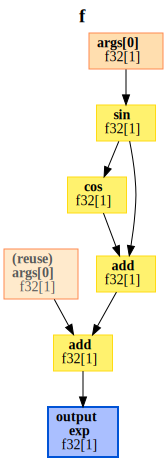

In [ ]:
def f(a):
  b = jnp.sin(a)
  c = jnp.cos(b)
  d = b + c
  e = a + d
  e = jnp.exp(e)
  return e

x = jnp.ones([1])
dot = hk.experimental.to_dot(f)(x)

import graphviz
graphviz.Source(dot)

In [3]:
import os
import sys

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)
    
from src.models.nucleotide_transformer import build_nucleotide_transformer_fn

build_nucleotide_transformer_fn(model_config=1)

<function src.models.nucleotide_transformer.build_nucleotide_transformer_fn.<locals>.nucleotide_transformer_fn(tokens: jax.Array, attention_mask: Optional[jax.Array] = None) -> Dict[str, jax.Array]>